In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data()

print('Train reviews: ', len(X_train))
print('Test reviews: ', len(X_test))
num_classes = max(y_train) + 1
print('Categories: ', num_classes)

Train reviews:  25000
Test reviews:  25000
Categories:  2


### 1. 데이터 전처리

In [5]:
# X_train은 이미 인코딩 되어 숫자들로 구성
# y_train은 1/0.  1이면 긍정 리뷰, 0이면 부정 리뷰
print(X_train[0])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


Reviews max length:  2494
Reviews avg length:  238.71364


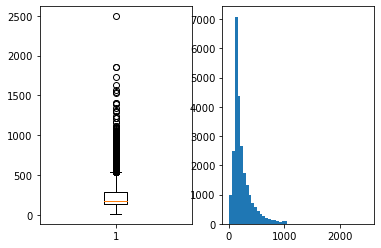

In [10]:
len_result = [len(s) for s in X_train]

print('Reviews max length: ', max(len_result))
print('Reviews avg length: ', np.mean(len_result))

plt.subplot(1, 2, 1)
plt.boxplot(len_result)
plt.subplot(1, 2, 2)
plt.hist(len_result, bins=50)
plt.show()

In [14]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[    0     1]
 [12500 12500]]


In [15]:
# imdb 데이터셋에서는 0, 1, 2, 3은 특별 토큰으로 취급하므로 value에 +3 하여 저장해야함
word_to_index = imdb.get_word_index()
index_to_word = {}

for key, value in word_to_index.items():
    index_to_word[value+3] = key

1646592/1641221 [==============================] - 0s 0us/step


In [16]:
print(index_to_word[4])
print(index_to_word[3941])

the
suited


In [18]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shoul

### 2. GRU로 IMDB 리뷰 감성 분석

In [59]:
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [60]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

In [61]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [62]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

# 검증 데이터 손실이 4회 증가하면 학습 중단 (조기 종료)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# 검증 데이터의 정확도가 이전보다 상승할 경우만 모델 저장
mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
334/334 [==============================] - ETA: 0s - loss: 0.4994 - acc: 0.7620
Epoch 00001: val_acc improved from -inf to 0.83540, saving model to GRU_model.h5
334/334 [==============================] - 172s 514ms/step - loss: 0.4994 - acc: 0.7620 - val_loss: 0.4276 - val_acc: 0.8354
Epoch 2/15
334/334 [==============================] - ETA: 0s - loss: 0.3137 - acc: 0.8762
Epoch 00002: val_acc improved from 0.83540 to 0.86840, saving model to GRU_model.h5
334/334 [==============================] - 180s 539ms/step - loss: 0.3137 - acc: 0.8762 - val_loss: 0.3198 - val_acc: 0.8684
Epoch 3/15
334/334 [==============================] - ETA: 0s - loss: 0.2418 - acc: 0.9093
Epoch 00003: val_acc did not improve from 0.86840
334/334 [==============================] - 217s 650ms/step - loss: 0.2418 - acc: 0.9093 - val_loss: 0.7512 - val_acc: 0.7664
Epoch 4/15
334/334 [==============================] - ETA: 0s - loss: 0.1942 - acc: 0.9268
Epoch 00004: val_acc improved from 0.86840 to 

In [63]:
loaded_model = load_model('GRU_model.h5')
print(loaded_model.evaluate(X_test, y_test)[1])

782/782 [==============================] - 88s 112ms/step - loss: 0.3456 - acc: 0.8864
0.8863999843597412


In [84]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub('[^0-9A-Za-z ]', '', new_sentence).lower()
    encoded = []
    
    for word in new_sentence.split():
        try:
            if word_to_index[word] <= 10000:
                encoded.append(word_to_index[word]+3)
            else:
                # 순위 10000 이상 단어 <unk> 토큰으로 취급
                encoded.append(2)
        # 단어 집합에 없는 단어 <unk> 토큰으로 취급
        except KeyError:
            encoded.append(2)
            
    pad_new = pad_sequences([encoded], maxlen=max_len)
    score = float(loaded_model.predict(pad_new))
    
    if score >= 0.5:
        print(round(score*100, 2), '% 확률로 긍정 리뷰')
    else:
        print(round((1-score)*100, 2), '% 확률로 부정 리뷰')

In [87]:
# 긍정적인 리뷰로 테스트 (10/10)
pos_review = '''
The Suicide Squad is an upgrade in every conceivable way when compared to the 2016 movie. Its also a really fun, gory, colorful and fresh take on the DC universe when compared to the dull, dark and overly edgy garbage of Movies like Batman vs Superman. As well as that, its nice to see a cast of characters that would likely never see the light of day in any other DC movie, Polka Dot man being a prime example. The casting itself was also really well done with Daniela Melchior being the standout to me.
'''

sentiment_predict(pos_review)

91.37 % 확률로 긍정 리뷰


In [86]:
# 부정적인 리뷰로 테스트 (1/10)
neg_review = '''
I have enjoyed most DC movies, but this is definitely something else. I just don't understand how some of these amazing actors agreed to something so bad. There were a couple of funny moments, but for the most part it was one of the worst movies I've watched.
'''

sentiment_predict(neg_review)

95.99 % 확률로 부정 리뷰
